In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder
import scipy
import itertools
from sklearn.feature_extraction.text import CountVectorizer
import unicodedata, re, string
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer


## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_4.csv')

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train[:10])

1160    rest spiritual furniture modest scattered tend...
557     meantime widow cranfield went bustling house f...
1181    offered hand took grasp became would seen fine...
1084    long reached spot rather tall house uninhabite...
253     seeing grown one fairest maidens many valorous...
802     call multiplied cares housekeeping without sub...
1119    use try follow farther to-night thought youth ...
34      period landing clive young writer india close ...
320     rudge could leave wife daughters without retur...
790     could come nothing kindly terms went engaged d...
Name: processed_text, dtype: object


## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
print(y_valid)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


# CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
X_train_cv = vectorizer.fit_transform(X_train).toarray()
X_test_cv = vectorizer.transform(X_test).toarray()
X_valid_cv = vectorizer.transform(X_valid).toarray()


In [ ]:
y_train.shape

(871, 20)

## Model 1

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_cv.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               47798784  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
# Train the model
history = model.fit(X_train_cv, y_train, validation_data=(X_valid_cv, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
109/109 [==============================] - 7s 28ms/step - loss: 3.9121 - accuracy: 0.1711 - val_loss: 2.1680 - val_accuracy: 0.4021
Epoch 2/10
109/109 [==============================] - 3s 29ms/step - loss: 1.6942 - accuracy: 0.5339 - val_loss: 1.2403 - val_accuracy: 0.7216
Epoch 3/10
109/109 [==============================] - 5s 43ms/step - loss: 1.1688 - accuracy: 0.7245 - val_loss: 0.7288 - val_accuracy: 0.9175
Epoch 4/10
109/109 [==============================] - 3s 29ms/step - loss: 0.5992 - accuracy: 0.9059 - val_loss: 0.4597 - val_accuracy: 0.9175
Epoch 5/10
109/109 [==============================] - 2s 17ms/step - loss: 0.5356 - accuracy: 0.9116 - val_loss: 0.8114 - val_accuracy: 0.7938
Epoch 6/10
109/109 [==============================] - 3s 28ms/step - loss: 0.2961 - accuracy: 0.9552 - val_loss: 0.1978 - val_accuracy: 0.9485
Epoch 7/10
109/109 [==============================] - 2s 17ms/step - loss: 0.2215 - accuracy: 0.9656 - val_loss: 0.2650 - val_accuracy: 0.9485

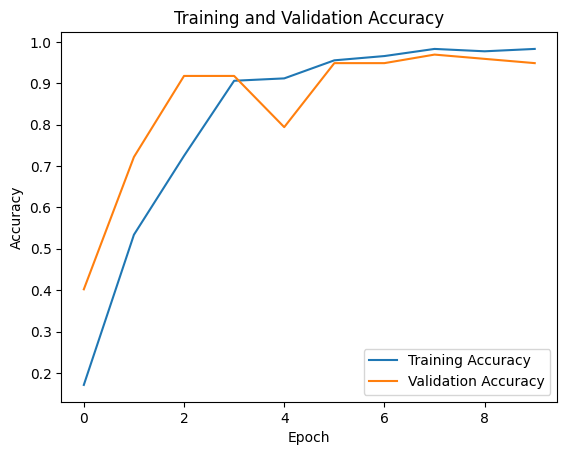

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_cv, y_test, verbose=0)

y_pred_probs = model.predict(X_test_cv)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

test_f1 = f1_score(y_test_indices, y_pred, average='macro')
test_precision = precision_score(y_test_indices, y_pred, average='macro')
test_recall = recall_score(y_test_indices, y_pred, average='macro')

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

8/8 [==============================] - 0s 7ms/step
Test loss: 0.18654142320156097
Test accuracy: 0.9793388247489929
Test F1 Score: 0.9754728599629617
Test Precision: 0.9788324175824176
Test Recall: 0.9737878787878789


# TextVectorization

## Model 2


In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
model = tf.keras.Sequential([
    vect_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 6000, 256)         15360000  
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/15
109/109 [==============================] - 15s 120ms/step - loss: 2.8058 - accuracy: 0.0953 - val_loss: 2.7538 - val_accuracy: 0.0825
Epoch 2/15
109/109 [==============================] - 12s 114ms/step - loss: 2.4637 - accuracy: 0.1837 - val_loss: 2.3649 - val_accuracy: 0.2371
Epoch 3/15
109/109 [==============================] - 12s 106ms/step - loss: 1.9421 - accuracy: 0.3307 - val_loss: 1.7512 - val_accuracy: 0.3814
Epoch 4/15
109/109 [==============================] - 12s 108ms/step - loss: 1.2976 - accuracy: 0.5626 - val_loss: 1.3069 - val_accuracy: 0.5361
Epoch 5/15
109/109 [==============================] - 12s 107ms/step - loss: 0.8329 - accuracy: 0.7382 - val_loss: 0.9913 - val_accuracy: 0.7216
Epoch 6/15
109/109 [==============================] - 12s 107ms/step - loss: 0.5484 - accuracy: 0.8416 - val_loss: 0.7417 - val_accuracy: 0.7526
Epoch 7/15
109/109 [==============================] - 11s 101ms/step - loss: 0.4045 - accuracy: 0.8863 - val_loss: 0.5744 - val_ac

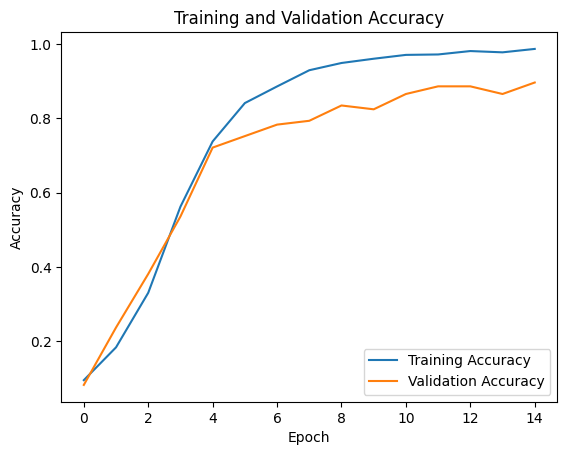

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 0s 49ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted')
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.8966942148760331
F1 Score: 0.8993582661294188
Precision: 0.9112361811741977
Recall: 0.8966942148760331


## Model 2 - vacsi vocab_site


In [ ]:
embedding_dim = 512
vocab_size = 90000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
model = tf.keras.Sequential([
    vect_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 6000)              0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 6000, 512)         46080000  
                                                                 
 global_average_pooling1d_1  (None, 512)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)              

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/15
109/109 [==============================] - 16s 133ms/step - loss: 2.8195 - accuracy: 0.1079 - val_loss: 2.7071 - val_accuracy: 0.1340
Epoch 2/15
109/109 [==============================] - 14s 129ms/step - loss: 2.2766 - accuracy: 0.2434 - val_loss: 2.0972 - val_accuracy: 0.2268
Epoch 3/15
109/109 [==============================] - 14s 129ms/step - loss: 1.5162 - accuracy: 0.4489 - val_loss: 1.3530 - val_accuracy: 0.5773
Epoch 4/15
109/109 [==============================] - 14s 129ms/step - loss: 0.8762 - accuracy: 0.7084 - val_loss: 0.9378 - val_accuracy: 0.6598
Epoch 5/15
109/109 [==============================] - 13s 120ms/step - loss: 0.4843 - accuracy: 0.8783 - val_loss: 0.6336 - val_accuracy: 0.7938
Epoch 6/15
109/109 [==============================] - 13s 117ms/step - loss: 0.2947 - accuracy: 0.9277 - val_loss: 0.4348 - val_accuracy: 0.8763
Epoch 7/15
109/109 [==============================] - 12s 113ms/step - loss: 0.1895 - accuracy: 0.9575 - val_loss: 0.4504 - val_ac

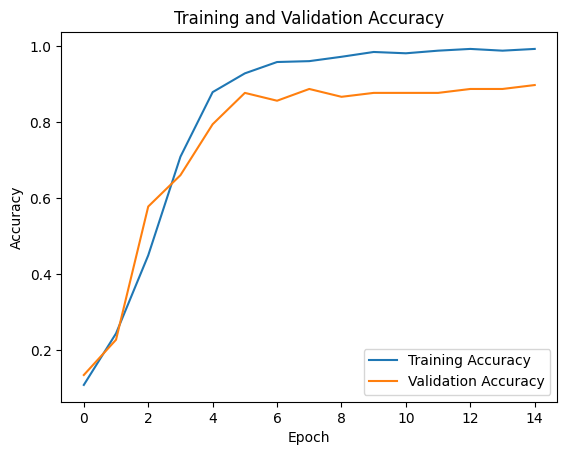

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 0s 50ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted')
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.9297520661157025
F1 Score: 0.9300416716604513
Precision: 0.9345595864190905
Recall: 0.9297520661157025
